# Библиотеки

In [1]:
import torch
import torchvision
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


# Выгрузка данных

In [2]:
df = pd.read_csv(
    'lenta-ru-news.csv'
)

/tmp/ipykernel_6253/1509519671.py:1: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(


In [3]:
df=df.copy()
print(df.shape)
print(df.columns)

(800975, 6)
Index(['url', 'title', 'text', 'topic', 'tags', 'date'], dtype='object')


In [4]:
df=df.copy()
df.shape

(800975, 6)

In [5]:
#слишком шумные топики (наблюдений менее 10)
remove_topics = ['Сочи', 'ЧМ-2014', 'МедНовости', 'Оружие']
df = df[~df['topic'].isin(remove_topics)]

In [6]:
df=df.dropna(axis=0)#избавимся от н/ашек
df.shape

(712647, 6)

# Базовый eda анализ

In [7]:
class_counts = df['topic'].value_counts()#глянем на баланс классов
print("📊 Баланс классов:")
print(class_counts)

📊 Баланс классов:
Россия               155004
Мир                  136620
Экономика             76423
Спорт                 57894
Культура              53530
Наука и техника       53136
Бывший СССР           51370
Интернет и СМИ        44421
Из жизни              27513
Дом                   21734
Силовые структуры     11223
Ценности               7581
Бизнес                 7375
Путешествия            6370
69-я параллель         1268
Крым                    666
Культпросвет            340
Легпром                 114
Библиотека               65
Name: topic, dtype: int64


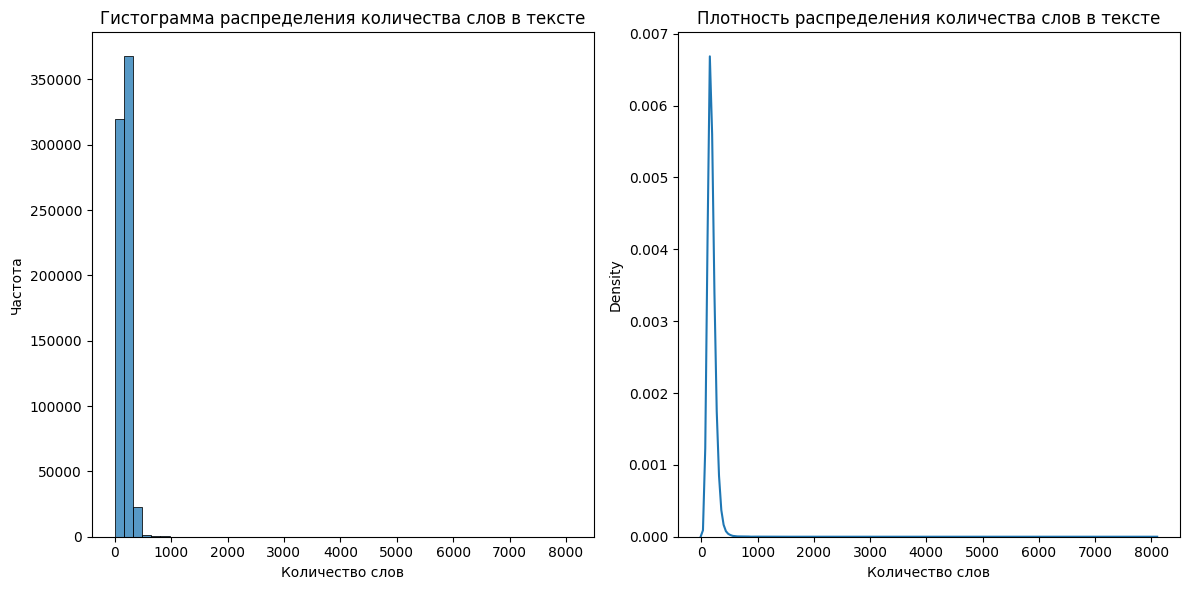

In [8]:
#глянем на среднюю длину статьи (около 800 но есть один выброс на 8000)
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
sns.histplot(df['word_count'], bins=50, kde=False)
plt.title('Гистограмма распределения количества слов в тексте')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.subplot(1,2,2)
sns.kdeplot(df['word_count'])
plt.title('Плотность распределения количества слов в тексте')
plt.xlabel('Количество слов')
plt.tight_layout()
plt.show()

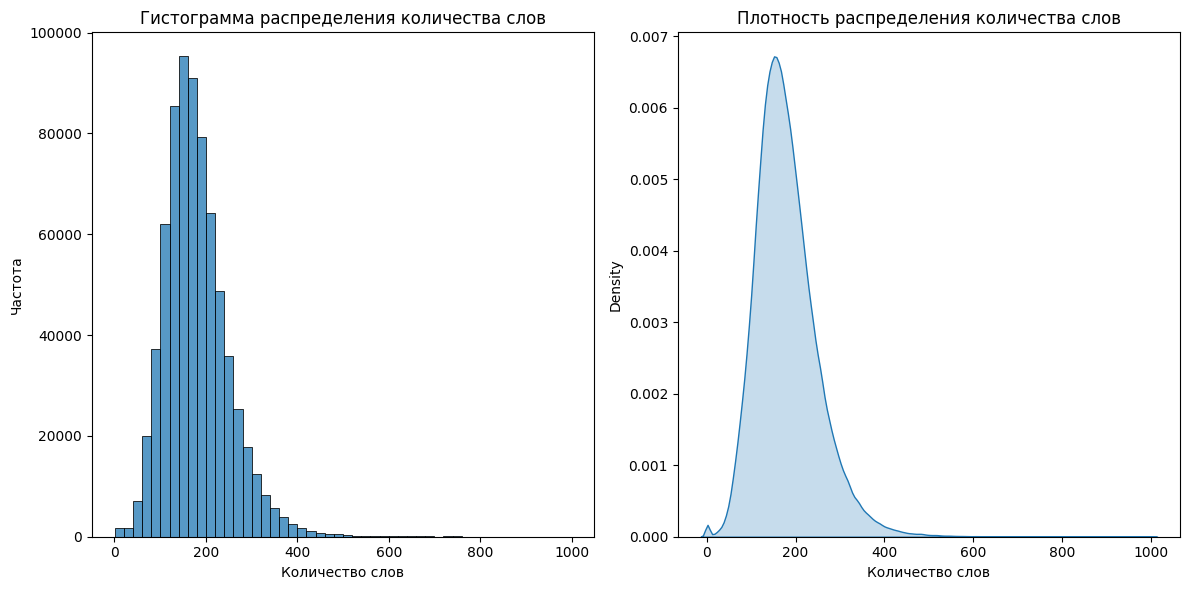

In [9]:
#уберем совсем выбросы
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))
filtered = df[df['word_count'] <= 1000]
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(filtered['word_count'], bins=50, kde=False)
plt.title('Гистограмма распределения количества слов')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.subplot(1, 2, 2)
sns.kdeplot(filtered['word_count'], fill=True)
plt.title('Плотность распределения количества слов')
plt.xlabel('Количество слов')
plt.tight_layout()
plt.show()

In [10]:
df['topic'].unique()

array(['Библиотека', 'Россия', 'Мир', 'Экономика', 'Интернет и СМИ',
       'Спорт', 'Культура', 'Из жизни', 'Наука и техника', 'Бывший СССР',
       'Дом', 'Путешествия', 'Силовые структуры', 'Ценности', 'Легпром',
       'Бизнес', '69-я параллель', 'Культпросвет ', 'Крым'], dtype=object)

# Бейслайн

In [11]:
class_counts = df['topic'].value_counts()
# оставляем классы, где >= 2 примеров (иначе ломалось)
valid_classes = class_counts[class_counts >= 2].index
df_filtered = df[df['topic'].isin(valid_classes)]
X_train, X_test, y_train, y_test = train_test_split(
    df_filtered['text'],
    df_filtered['topic'],
    test_size=0.2,
    stratify=df_filtered['topic']
)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

In [12]:
model = CatBoostClassifier(
    iterations=300,
    depth=6,
    learning_rate=0.1,
    loss_function='MultiClass',
    task_type="GPU",  
    devices='0',
    verbose=50
)

model.fit(X_train_vec, y_train)
y_pred = model.predict(X_test_vec)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

0:	learn: 2.6393525	total: 4.14s	remaining: 20m 38s
50:	learn: 1.3865253	total: 35.4s	remaining: 2m 52s
100:	learn: 1.1824287	total: 1m 5s	remaining: 2m 9s
150:	learn: 1.0623733	total: 1m 35s	remaining: 1m 34s
200:	learn: 0.9852901	total: 2m 5s	remaining: 1m 1s
250:	learn: 0.9254817	total: 2m 34s	remaining: 30.2s
299:	learn: 0.8814492	total: 3m 3s	remaining: 0us
Accuracy: 0.7376692626113801


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report:
                    precision    recall  f1-score   support

   69-я параллель       0.00      0.00      0.00       253
       Библиотека       0.00      0.00      0.00        13
           Бизнес       0.66      0.16      0.26      1475
      Бывший СССР       0.75      0.74      0.74     10274
              Дом       0.84      0.61      0.71      4347
         Из жизни       0.63      0.27      0.38      5503
   Интернет и СМИ       0.72      0.53      0.61      8884
             Крым       1.00      0.01      0.01       133
    Культпросвет        0.57      0.06      0.11        68
         Культура       0.82      0.78      0.80     10706
          Легпром       0.00      0.00      0.00        23
              Мир       0.69      0.82      0.75     27324
  Наука и техника       0.81      0.75      0.78     10627
      Путешествия       0.74      0.26      0.38      1274
           Россия       0.67      0.83      0.74     31001
Силовые структуры       0.75   

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


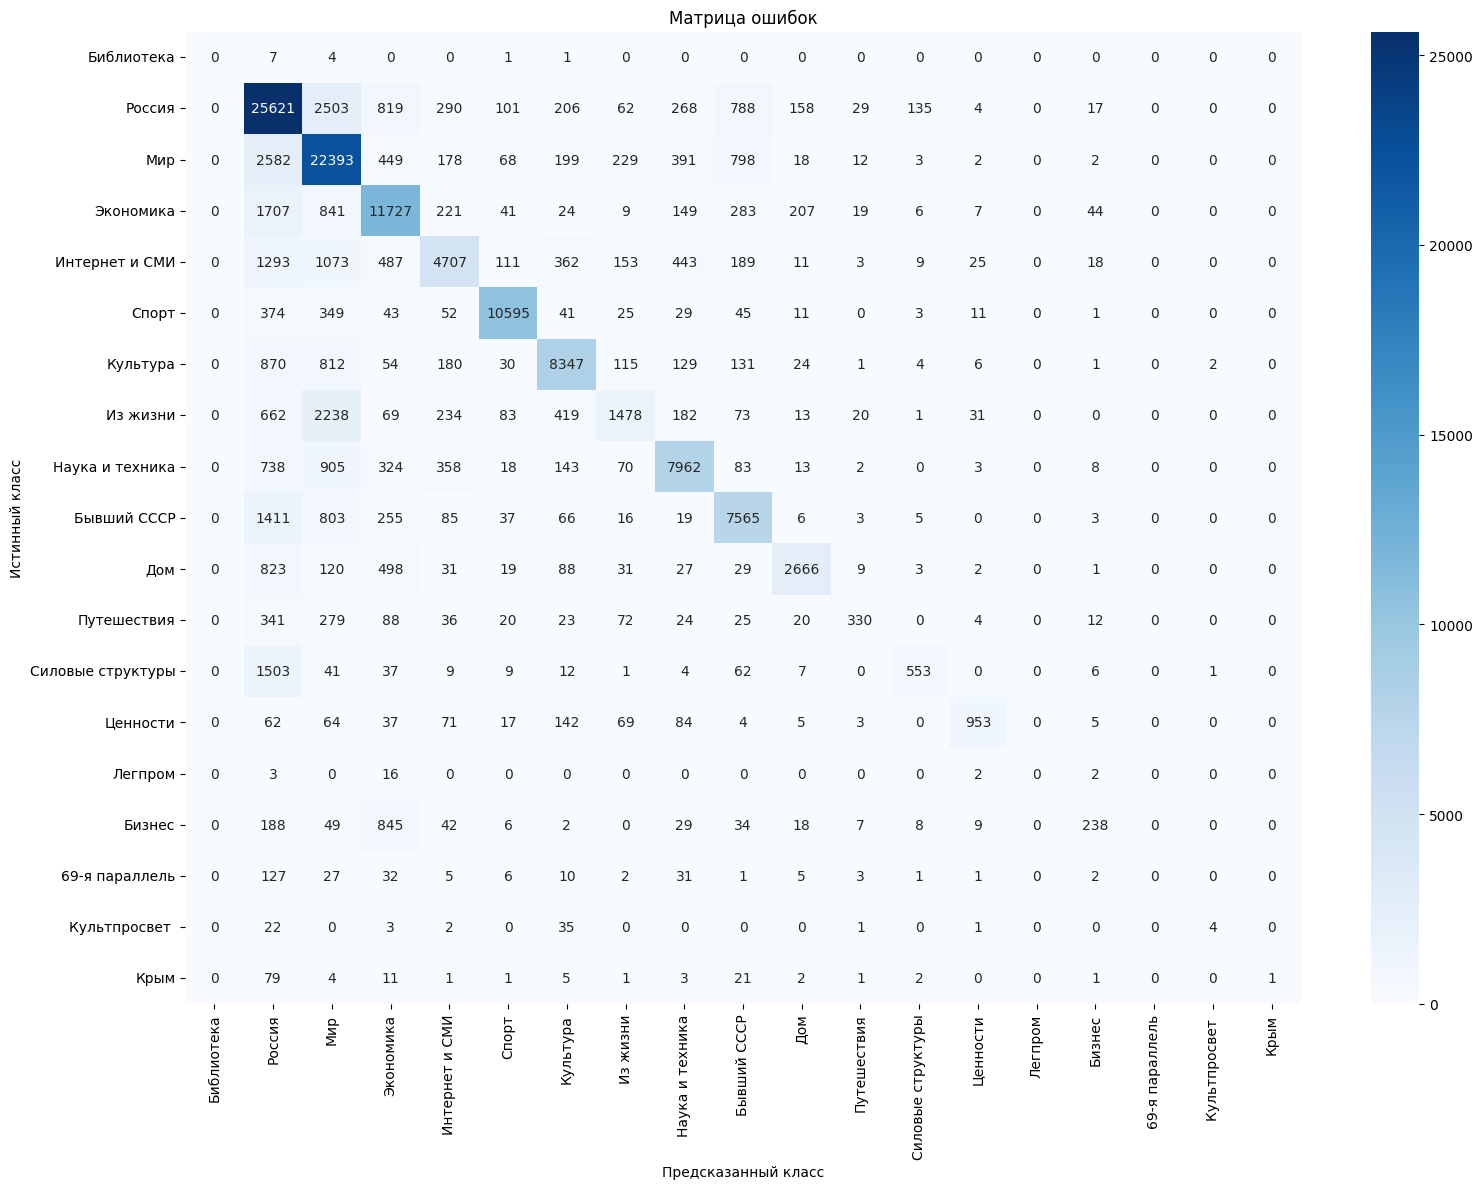

In [13]:

y_pred = model.predict(X_test_vec)
cm = confusion_matrix(y_test, y_pred, labels=df_filtered['topic'].unique())
plt.figure(figsize=(16, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=df_filtered['topic'].unique(), 
            yticklabels=df_filtered['topic'].unique())

plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.title('Матрица ошибок')
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [14]:
#в следующем ноутбуке попытаемся реализовать адаптивную к домену классиикацию и выгрузить обученные модели
#у бейслайна в целом результат тоже неплохой
#в матрице отрисовались несколько удаленных классов (совсем мало представителей этих классов было)